# Estimator only 

This workbook only estimates LRs, taking in various spreadsheet configurations. 

Inteded to support the use cases for the automated feedback generator. 


In [3]:
import requests
from bs4 import BeautifulSoup
import time
import pandas as pd
import numpy as np
import re
import math
import os
import json
from pydantic import BaseModel
from openai import OpenAI  # or your appropriate client wrapper
import math
from dotenv import load_dotenv
from __future__ import annotations

load_dotenv()  # looks for a .env file in the current dir by default
#print(os.getenv("OPENAI_API_KEY"))


True

### Old version 

Without any revamping to attempt to increase performance

In [ ]:
# Define the response schema expecting a floating point number.
class LRResponse(BaseModel):
    value: float

def estimate_lr(diagnosis: str, info_val: str, client, model: str) -> float:
    """
    Calls the LLM with a prompt containing the diagnosis and a finding.
    Returns the estimated likelihood ratio as a floating point number.
    """
    lr_prompt = """You are an expert in medical diagnosis who is giving assessments of how important a piece of information is when determining whether a patient has a particularly condition. Your task is to estimate the likelihood ratio of a finding for a disease. Recall that the likelihood ratio represents how much the ratio between the odds of disease given a result for a lab value, whether a physical exam finding is present, or whether a comorbidity is present over the odds of disease when you did not know the result.
You will receive inputs in the following format; Target condition: <Condition, e.g. Patient Has: Cardiac chest pain>. Finding: <piece of information, e.g. ‘Patient does not have: radiation to the neck, arm, or jaw’>.
So, for example. If the odds of a Condition Z being present was 1 (meaning 50% probability) before we knew anything, but then we got a result (Finding A) it became 2 (meaning 2:1 odds or 66% probability), then the likelihood ratio would be 2. 
Given a condition and a finding, you will provide your best estimate of the likelihood ratio as a floating point number. Return your answer in valid JSON with the following schema: { 'value': <floating point number greater than 0> }.\n\n

Remember, stronger evidence in favor of a condition has a value farther above 1. Strong evidence against a diagnosis has a value farther below 1 (closer to 0). A likelihood ratio of 10 is equally strong evidence for a condition as a likelihood ratio of 0.1 is against it. Likelihood ratios near 1 represent weak evidence for or against. 
And if the "patient does not have: " some feature that is almost always present, that is strong evidence against.
(pay attention for double negatives- Patient has: no tobacco and Patient does not have: tobacco are identical)

Here is how I would like you to approach the problem:
First, consider the condition you are predicting (Condition: ___). Is the condition a medical diagnosis? If so, what kind of findings are usually present in someone who has that condition. Does the condition specify a certain type of patient? If so, how does that change things? 
Then, consider the finding. If a finding is much more common among patients who have the condition of interest than among patients who do not have the condition of interest, then the likelihood ratio should be high. This might be because the finding is a consequence of the disease, indicates that an enabling condition is present, indicates that a frequently comorbid condition is present, or is related to the pathology of the condition. In general, likelihood ratios over about 20 are pathognomonic, above 5 or so is extremely strong evidence in favor, above 2.5 or so is strong evidence, above 1.4 is so-so evidence, and 1-1.4 is pretty weak evidence. Conversely, if the finding is more common in people who do NOT have the condition, then the likelihood ratio should be below 0. Similarly, a likelihood ratio below 0.05 would exclude the condition in most situations, below 0.2 would be extremely strong evidence against, below 0.4 would be strong evidence against, below 0.71 is so-so, and between 0.71 and 1 is pretty weak evidence against (meaning, it just doesn’t change the odds of the condition much). 

Here are some hypothetical examples to consider: 
    Prompt = Target condition: Cardiac Chest Pain. Finding: Patient has: Pain not worse with exertion (requires they clarify exercise 1hr after meal).
    You would reason that because cardiac chest pain is usually worse with exertion because exertion worsens cardiac demand for oxygen, and thus worsens ischemia.
    Response = {
        ‘value’: 0.4
    }

    Prompt =  Target condition: Cardiac Chest Pain. Finding: Patient does not have: tobacco.
    You would reason that because being someone who smokes increases your risk of coronary artery disease, and thus being a never smoker means you’re at less risk… but many people who have heart attacks still smoke, so it’s only a weak predictor. 
    Response = {
        ‘value’: 0.75
    }

    Prompt = Target condition: Cardaic Chest Pain. Finding = Patient has: enjoys playing chess.
    You would reason that because enjoying chest has no relationship to having a heart attack.
    Response = {
        ‘value’: 1
    }

    Prompt = Target condition: Cardiac Chest Pain. Finding = Patient has: pain located behind the sternum
    You would reason that because cardiac chest pain is often experienced behind the sternum (thus, more likely), but so are many other causes of chest pain - like GERD.
    Response = {
        ‘value’: 1.2
    }

    Prompt = Condition: Cardiac Chest Pain. Finding = patient has: pain worse with exertion.
    You would reason that because the increased myocardial oxygen consumption worsens the pain if oxygen delivery to the myocardium is the cause, as it is in heart attacks.
    Response = {
        ‘value’: 3.4
    }

    OK: here’s the prompt.. """
    
    messages = [
        {"role": "system", "content": lr_prompt},
        {"role": "user", "content": f"Condition: {diagnosis}\nFinding: {info_val}"}
    ]

    # Check if the model starts with "o3-mini" "o3" "o4-mini, "o4", etc.
    kwargs = {}
    if model.startswith("o"):
        kwargs["reasoning_effort"] = "medium"  # low, medium, high depending on need

    # Call the LLM using the provided model name.
    completion = client.beta.chat.completions.parse(
        model=model,
        messages=messages,
        response_format=LRResponse,
        **kwargs  # pass the conditional keyword argument
    )

    # Call the LLM using the provided model name.
    completion = client.beta.chat.completions.parse(
        model=model,  # use the current model from the list
        messages=messages,
        response_format=LRResponse,
    )
    
    # Extract and return the floating point estimate.
    lr_response = completion.choices[0].message.parsed
    return lr_response.value


# Initialize the OpenAI (or your chosen) client using your API key.
client = OpenAI(api_key=os.environ["OPENAI_API_KEY"])

# List of model names to iterate over.
model_names = ['gpt-4o-mini-2024-07-18'] #['gpt-4o-mini-2024-07-18', 'gpt-4.1-mini-2025-04-14', 'gpt-4.1-2025-04-14', 'o4-mini-2025-04-16'] #'gpt-4o-2024-08-06', 'o3-mini-2025-01-31', gpt-4.1-2025-04-14, o4-mini-2025-04-16, 'o3-2025-04-16']

# Read the processed Excel file.
# We use header=None so that row 0 (the diagnosis row) and row 1 (the column headers row) are preserved.
input_filename = "nnt_lrs_processed.xlsx"
#input_filename = "new_" \
#"nnt_lrs_processed.xlsx" # use this one for the substitute in
sheets = pd.read_excel(input_filename, sheet_name=None, header=None)

# Process each sheet
for sheet_name, df in sheets.items():
    # Set diagnosis from the first row (row index 0, first cell)
    diagnosis = df.iloc[0, 0]

    # For each model in the list, call the LLM and add a new column with the estimation.
    for model in model_names:
        new_col_header = "lr_" + model
        new_col = []  # This list will hold one value per row
        print(f"Diagnosis: '{diagnosis}', Model: '{model}'")

        # Iterate over each row in the sheet.
        # Row 0 is the diagnosis row; row 1 is the existing column labels.
        for i in range(len(df)):
            if i == 0:
                new_col.append("")  # Leave the diagnosis row unchanged.
            elif i == 1:
                new_col.append(new_col_header)  # Insert the new column header in row 1.
            else:
                # For data rows, use the "finding" from the first column (index 0)
                info_val = df.iloc[i, 0]
                try:
                    estimated_lr = estimate_lr(diagnosis, info_val, client, model)
                except Exception as e:
                    estimated_lr = "ERROR"  
                    print(f"Error estimating LR for sheet '{sheet_name}', row {i}, model {model}: {e}")
                new_col.append(estimated_lr)
        
        # Insert the new column at the end of the dataframe.
        df.insert(df.shape[1], new_col_header, new_col)
    
    # Update the sheet data in our dictionary.
    sheets[sheet_name] = df

# Write out the modified sheets to a new Excel file.
output_filename = "nnt_lrs_with_estimated.xlsx"
with pd.ExcelWriter(output_filename, engine="openpyxl") as writer:
    for sheet_name, df in sheets.items():
        # Write without adding pandas default headers or indices.
        df.to_excel(writer, sheet_name=sheet_name, index=False, header=False)

print(f"Processed Excel file saved as '{output_filename}'")

## Scripts to perform the data processing for Cory's July/2025 reasoning request


### Reasoning about categories

"can you run the LRs for each grouping (second attachment) and add LRs to a few rows to round out the addition of a pulmonary grouping (see rows 91-94)? All additions of diagnoses or key features are highlighted in yellow. First few rows of second attachment include sub-groupings but guessing this is getting too complex for this pilot stage." 

In [ ]:
"""
Estimate likelihood‑ratios (LRs) for every (finding × disease‑category) pair in a
single‑sheet Excel workbook whose first column lists findings and whose first row
lists the disease categories.

Input  workbook example   :  est_lrs_by_category.xlsx
Output workbook produced  :  est_lrs_by_category_filled.xlsx
───────────────────────────────────────────────────────────────────────────────
Layout assumed
─────────────
• Sheet #0 is the *only* sheet that will be processed.
• Row 0 (index 0): disease‑category targets.  
  – Cell A1 may read “Diagnosis:” or be blank; all other non‑blank cells in
    that first row are treated as separate prediction targets.

• Column 0 (index 0), rows ≥ 1: findings (free‑text strings beginning with
  “Patient Has:” / “Patient Does Not Have:”, etc.).
  – All other cells initially *empty* → will be populated with LR estimates.

The script preserves the original layout and simply fills the empty cells with
floating‑point LR values (or “ERROR” if the LLM call fails).

Multiple models?
────────────────
`model_names` can contain one or many model IDs.  
If you list more than one model, each model gets its *own* sheet in the output
workbook, all named after the model ID.  (The original sheet is left unchanged
in that case.)

Dependencies
────────────
openai >= 1.0,  pydantic >= 2,  pandas,  openpyxl
"""

# ──────────────────────────────────────────────────────────────────────────────
# 1.  CONFIGURATION  ───────────────────────────────────────────────────────────
# ──────────────────────────────────────────────────────────────────────────────

INPUT_FILE  = "/Users/blocke/Box Sync/Residency Personal Files/Scholarly Work/Locke Research Projects/llm_estimate_lrs/data_jul_21_2025/est_lrs_by_category.xlsx"
OUTPUT_FILE = "/Users/blocke/Box Sync/Residency Personal Files/Scholarly Work/Locke Research Projects/llm_estimate_lrs/data_jul_21_2025/est_lrs_by_category_filled.xlsx"

# Provide one or many model IDs here.
model_names = ["o3-2025-04-16"] # ["gpt-4o-mini-2024-07-18"] 

# Optional: tune reasoning depth for o‑series models.
REASONING_EFFORT = "medium"   # "low" | "medium" | "high"


# ──────────────────────────────────────────────────────────────────────────────
# 2.  RESPONSE SCHEMA  ────────────────────────────────────────────────────────
# ──────────────────────────────────────────────────────────────────────────────

class LRResponse(BaseModel):
    value: float


# ──────────────────────────────────────────────────────────────────────────────
# 3.  LLM CALL  ───────────────────────────────────────────────────────────────
# ──────────────────────────────────────────────────────────────────────────────

LR_PROMPT_TEMPLATE = """You are an expert in medical diagnosis whose task is
to estimate a *likelihood ratio* (LR) for a finding with respect to a category of conditions.

You are an expert in medical diagnosis who is giving assessments of how important a piece of information 
is when determining whether a patient has a particularly type of condition condition. 

Your task is to estimate the likelihood ratio of a finding for a category of disease. 

Recall that the likelihood ratio represents how much the ratio between the odds of disease given a result 
for a lab value, whether a physical exam finding is present, or whether a comorbidity is present over the 
odds of disease when you did not know the result.

You will receive inputs in the following format: 
Condition: <A category of interest, followed by the specific diseases that make up that category, e.g. "cardiac">. 
Finding: <piece of information, e.g. ‘Patient does not have: radiation to the neck, arm, or jaw’>.

So, for example. If the odds of a Condition Z being present was 1 (meaning 50% probability) before we knew anything, 
but then we got a result (Finding A) it became 2 (meaning 2:1 odds or 66% probability), 
then the likelihood ratio would be 2. 

Given a category of diseases and a finding, you will provide your best estimate of the likelihood ratio as a floating point number. 
Return your answer in valid JSON with the following schema: { 'value': <floating point number greater than 0> }.\n\n

Remember, stronger evidence in favor of a condition has a value farther above 1. 
Strong evidence against a diagnosis has a value farther below 1 (closer to 0). 
A likelihood ratio of 10 is equally strong evidence for a condition as a likelihood ratio of 0.1 is against it. 
Likelihood ratios near 1 represent weak evidence for or against. 
If the "patient does not have: " some feature that is almost always present, that is strong evidence against.
(pay attention for double negatives- Patient has: no tobacco and Patient does not have: tobacco are identical)

Here is how I would like you to approach the problem:
First, consider the category of diseases you are predicting (Condition: ___). 
Is the condition a medical diagnosis? 
If so, what kind of findings are usually present in someone who has that condition. 
Does the condition specify a certain type of patient? 
If so, how does that change things? 
Then, consider the finding. 
If a finding is much more common among patients who have the condition of interest than among patients who do not have the condition of interest, 
then the likelihood ratio should be high. 
This might be because the finding is a consequence of the disease, 
indicates that an enabling condition is present, 
indicates that a frequently comorbid condition is present, 
or is related to the pathology of the condition. 

In general, likelihood ratios over about 20 are pathognomonic, 
above 5 or so is extremely strong evidence in favor, 
above 2.5 or so is strong evidence, 
above 1.4 is so-so evidence, 
and 1-1.4 is pretty weak evidence. 

Conversely, if the finding is more common in people who do NOT have the condition, 
then the likelihood ratio should be below 1. 

Similarly, a likelihood ratio below 0.05 would exclude the condition in most situations, 
below 0.2 would be extremely strong evidence against, 
below 0.4 would be strong evidence against, 
below 0.71 is so-so, 
and between 0.71 and 1 is pretty weak evidence against (meaning, it just doesn’t change the odds of the condition much). 

Return JSON: {{ "value": <float >0 }}  (no additional keys).
Reply *only* with the JSON object.
"""

def estimate_lr(
    condition: str,
    finding: str,
    client: OpenAI,
    model: str,
) -> float | str:
    """Call the LLM and return a floating‑point LR (or the string 'ERROR')."""
    sys_msgs = [{"role": "system", "content": LR_PROMPT_TEMPLATE}]
    user_msg = {"role": "user",
                "content": f"Condition: {condition}\nFinding: {finding}"}

    # Build request kwargs.
    kwargs: dict = {}
    if model.startswith("o"):          # o3, o3‑mini, o4‑mini, o4, etc.
        kwargs["reasoning_effort"] = REASONING_EFFORT

    print(f"LLM call → model='{model}' | condition='{condition}' | finding='{finding}'")

    try:
        completion = client.beta.chat.completions.parse(
            model=model,
            messages=[*sys_msgs, user_msg],
            response_format=LRResponse,
            **kwargs,
        )
        return completion.choices[0].message.parsed.value
    except Exception as exc:           # catch any parsing / API error
        print(f"LLM error ({model}): {exc}")
        return "ERROR"


# ──────────────────────────────────────────────────────────────────────────────
# 4.  MAIN MATRIX‑FILLING LOGIC  ──────────────────────────────────────────────
# ──────────────────────────────────────────────────────────────────────────────

def fill_matrix(df: pd.DataFrame, model: str, client: OpenAI) -> pd.DataFrame:
    """Return a *copy* of `df` with all blank data cells filled for one model."""
    df_filled = df.copy(deep=True)

    # Identify disease categories (non‑NaN entries) in the first row, skipping col 0.
    categories: dict[int, str] = {col: str(df.iloc[0, col]).strip()
                                  for col in range(1, df.shape[1])
                                  if pd.notna(df.iloc[0, col]) and str(df.iloc[0, col]).strip()}
    if not categories:
        raise ValueError("No disease categories detected in row 0.")

    # Iterate over findings (rows ≥ 1)
    for row in range(1, df.shape[0]):
        finding = df.iloc[row, 0]
        if pd.isna(finding) or not str(finding).strip():
            # Skip completely empty rows
            continue

        for col, diagnosis in categories.items():
            # Only fill previously blank / NaN cells.
            if pd.isna(df_filled.iloc[row, col]) or df_filled.iloc[row, col] == "":
                lr = estimate_lr(diagnosis, finding, client, model)
                df_filled.iat[row, col] = lr

    return df_filled


#### Non plus_minus version

In [ ]:
# ──────────────────────────────────────────────────────────────────────────────
# 5.  DRIVER CODE  ────────────────────────────────────────────────────────────
# ──────────────────────────────────────────────────────────────────────────────

def main() -> None:
    # Load workbook (first sheet only, no header inference).
    df = pd.read_excel(INPUT_FILE, sheet_name=0, header=None)

    # drop columns that are completely empty (all NaN or all empty/whitespace)
    df = df.loc[:, ~(df.replace("", pd.NA).isna().all())]

    # Initialise client.
    client = OpenAI(api_key=os.environ["OPENAI_API_KEY"])

    # Either a single model (update in‑place) or multiple models (one sheet each).
    with pd.ExcelWriter(OUTPUT_FILE, engine="openpyxl") as writer:
        if len(model_names) == 1:
            filled = fill_matrix(df, model_names[0], client)
            filled.to_excel(writer, sheet_name="LRs", index=False, header=False)
        else:
            for model in model_names:
                filled = fill_matrix(df, model, client)
                filled.to_excel(writer, sheet_name=model, index=False, header=False)

    print(f"Completed workbook saved →  {OUTPUT_FILE}")

main()

#### Plus-Minus Categories

In [ ]:
# Plus-Minus Categories Code here

# ---------------------------------------------------------------------------
# PLUS‑MINUS  C A T E G O R I E S
# ---------------------------------------------------------------------------
import os
import pandas as pd
from openai import OpenAI

# -------------------------------------------------------------------------
INPUT_PM_CAT  = "/Users/blocke/Box Sync/Residency Personal Files/Scholarly Work/Locke Research Projects/llm_estimate_lrs/data_jul_21_2025/est_lrs_by_category_for_plusminus.xlsx"
OUTPUT_PM_CAT = "/Users/blocke/Box Sync/Residency Personal Files/Scholarly Work/Locke Research Projects/llm_estimate_lrs/data_jul_21_2025/est_lrs_by_category_plusminus_filled.xlsx"

# Uses the same `model_names`, `estimate_lr`, and `fill_matrix`
# that were defined in the earlier “Reasoning about categories” section.
# -------------------------------------------------------------------------

def build_plusminus_df(df: pd.DataFrame) -> pd.DataFrame:
    """Return a new dataframe where every finding is duplicated into
       'Patient has:' and 'Patient does not have:' variants."""
    header = df.iloc[0].copy()
    findings = df.iloc[1:, 0].dropna().astype(str).str.strip()

    pm_rows = []
    for f in findings:
        low = f.lower()
        if low.startswith("patient has:") or low.startswith("patient does not have:"):
            pm_rows.append(f)                 # already prefixed → keep single row
        else:
            pm_rows.append(f"Patient has: {f}")
            pm_rows.append(f"Patient does not have: {f}")

    # Build an empty frame, copy header, insert the new finding rows
    df_pm = pd.DataFrame(
        "",
        index=range(len(pm_rows) + 1),
        columns=df.columns,
    )
    df_pm.iloc[0] = header
    df_pm.iloc[1:, 0] = pm_rows

    # Drop columns that are completely empty (Excel artefacts)
    return df_pm.loc[:, ~(df_pm.replace("", pd.NA).isna().all())]


# ––– LOAD, EXPAND, RUN –––––––––––––––––––––––––––––––––––––––––––––––––––––––
df_orig = pd.read_excel(INPUT_PM_CAT, sheet_name=0, header=None)
df_plusminus = build_plusminus_df(df_orig)

client = OpenAI(api_key=os.getenv("OPENAI_API_KEY"))

with pd.ExcelWriter(OUTPUT_PM_CAT, engine="openpyxl") as writer:
    if len(model_names) == 1:
        fill_matrix(df_plusminus, model_names[0], client) \
            .to_excel(writer, sheet_name="LRs", index=False, header=False)
    else:
        for m in model_names:
            fill_matrix(df_plusminus, m, client) \
                .to_excel(writer, sheet_name=m, index=False, header=False)

print(f"✔  Plus‑minus (categories) workbook saved → {OUTPUT_PM_CAT}")

### Diseases

In [ ]:
"""
Fill a (finding × disease) matrix with LLM‑estimated likelihood ratios (LRs).

• Workbook layout ----------------------------------------
  ┌───────────┬──────────────┬─────────────┬───┐
  │           │  Col‑1       │  Col‑2      │ … │
  │ Row‑0     │ Disease #1   │ Disease #2  │ … │ ← targets
  │ Row‑1…N   │ Finding 1    │             │   │
  │           │ Finding 2    │             │   │
  └───────────┴──────────────┴─────────────┴───┘
  – Sheet 0 only.  
  – Column‑0 (rows ≥1) holds findings; other cells start blank and will be filled.

• Multiple models?  
  – `model_names` may list one or many model IDs.  
  – With >1 model each sheet in the output is named after the model.

Dependencies:  openai  |  pandas  |  pydantic  |  openpyxl
"""

# ─── 1. CONFIGURATION ────────────────────────────────────────────────────────
INPUT_FILE  = "/Users/blocke/Box Sync/Residency Personal Files/Scholarly Work/Locke Research Projects/llm_estimate_lrs/data_jul_21_2025/est_lrs_by_disease.xlsx"
OUTPUT_FILE = "/Users/blocke/Box Sync/Residency Personal Files/Scholarly Work/Locke Research Projects/llm_estimate_lrs/data_jul_21_2025/est_lrs_by_disease_filled.xlsx"

# Provide one or many model IDs here.
model_names = ["o3-2025-04-16"] #["gpt-4o-mini-2024-07-18"] # 

# Optional: tune reasoning depth for o‑series models.
REASONING_EFFORT = "low"   # "low" | "medium" | "high"


# ─── 2. RESPONSE SCHEMA ──────────────────────────────────────────────────────
class LRResponse(BaseModel):
    value: float

# ─── 3. PROMPT ───────────────────────────────────────────────────────────────
LR_PROMPT_TEMPLATE = """You are an expert in medical diagnosis who is giving assessments of how important a piece of information is when determining whether a patient has a particularly condition. 
Your task is to estimate the likelihood ratio of a finding for a disease. 
Recall that the likelihood ratio represents how much the ratio between the odds of disease given a result for a lab value, whether a physical exam finding is present, or whether a comorbidity is present over the odds of disease when you did not know the result.
You will receive inputs in the following format; Target condition: <Condition, e.g. Patient Has: Cardiac chest pain>. Finding: <piece of information, e.g. ‘Patient does not have: radiation to the neck, arm, or jaw’>.
So, for example. If the odds of a Condition Z being present was 1 (meaning 50% probability) before we knew anything, but then we got a result (Finding A) it became 2 (meaning 2:1 odds or 66% probability), then the likelihood ratio would be 2. 
Given a condition and a finding, you will provide your best estimate of the likelihood ratio as a floating point number. Return your answer in valid JSON with the following schema: { 'value': <floating point number greater than 0> }.\n\n

Remember, stronger evidence in favor of a condition has a value farther above 1. Strong evidence against a diagnosis has a value farther below 1 (closer to 0). A likelihood ratio of 10 is equally strong evidence for a condition as a likelihood ratio of 0.1 is against it. Likelihood ratios near 1 represent weak evidence for or against. 
And if the "patient does not have: " some feature that is almost always present, that is strong evidence against.
(pay attention for double negatives- 'Patient has: no tobacco use' and 'Patient does not have: tobacco use' are identical)

Here is how I would like you to approach the problem:
First, consider the condition you are predicting (Condition: ___). 
Is the condition a medical diagnosis? If so, what kind of findings are usually present in someone who has that condition. 
Does the condition specify a certain type of patient? If so, how does that change things? 
Then, consider the finding. 
If a finding is much more common among patients who have the condition of interest than among patients who do not have the condition of interest, then the likelihood ratio should be high. 
This might be because the finding is a consequence of the disease, indicates that an enabling condition is present, indicates that a frequently comorbid condition is present, or is related to the pathology of the condition. 
In general, likelihood ratios over about 20 are pathognomonic, above 5 or so is extremely strong evidence in favor, above 2.5 or so is strong evidence, above 1.4 is so-so evidence, and 1-1.4 is pretty weak evidence. 
Conversely, if the finding is more common in people who do NOT have the condition, then the likelihood ratio should be below 1. 
Similarly, a likelihood ratio below 0.05 would exclude the condition in most situations, below 0.2 would be extremely strong evidence against, below 0.4 would be strong evidence against, below 0.71 is so-so, and between 0.71 and 1 is pretty weak evidence against (meaning, it just doesn’t change the odds of the condition much). 

Here are some hypothetical examples to consider: 
    Prompt = Target condition: Cardiac Chest Pain. Finding: Patient has: Pain not worse with exertion (requires they clarify exercise 1hr after meal).
    You would reason that because cardiac chest pain is usually worse with exertion because exertion worsens cardiac demand for oxygen, and thus worsens ischemia.
    Response = {
        ‘value’: 0.4
    }

    Prompt =  Target condition: Cardiac Chest Pain. Finding: Patient does not have: tobacco.
    You would reason that because being someone who smokes increases your risk of coronary artery disease, and thus being a never smoker means you’re at less risk… but many people who have heart attacks still smoke, so it’s only a weak predictor. 
    Response = {
        ‘value’: 0.75
    }

    Prompt = Target condition: Cardaic Chest Pain. Finding = Patient has: enjoys playing chess.
    You would reason that because enjoying chest has no relationship to having a heart attack.
    Response = {
        ‘value’: 1
    }

    Prompt = Target condition: Cardiac Chest Pain. Finding = Patient has: pain located behind the sternum
    You would reason that because cardiac chest pain is often experienced behind the sternum (thus, more likely), but so are many other causes of chest pain - like GERD.
    Response = {
        ‘value’: 1.2
    }

    Prompt = Condition: Cardiac Chest Pain. Finding = patient has: pain worse with exertion.
    You would reason that because the increased myocardial oxygen consumption worsens the pain if oxygen delivery to the myocardium is the cause, as it is in heart attacks.
    Response = {
        ‘value’: 3.4
    }

    OK: here’s the prompt.. """

# ─── 4. LLM CALL ──────────────────────────────────────────────────────────────
def estimate_lr(
    disease: str,
    finding: str,
    client: OpenAI,
    model: str,
) -> float | str:
    """Return LR or 'ERROR'."""
    sys_msgs = [{"role": "system", "content": LR_PROMPT_TEMPLATE}]
    user_msg = {"role": "user",
                "content": f"Condition: {disease}\nFinding: {finding}"}
    kwargs: dict = {}
    if model.startswith("o"):
        kwargs["reasoning_effort"] = REASONING_EFFORT

    print(f"LLM call → model='{model}' | disease='{disease}' | finding='{finding}'")

    try:
        completion = client.beta.chat.completions.parse(
            model=model,
            messages=[*sys_msgs, user_msg],
            response_format=LRResponse,
            **kwargs,
        )
        return completion.choices[0].message.parsed.value
    except Exception as exc:
        print(f"LLM error ({model}): {exc}")
        return "ERROR"

# ─── 5. MATRIX FILL ──────────────────────────────────────────────────────────
def fill_matrix(df: pd.DataFrame, model: str, client: OpenAI) -> pd.DataFrame:
    """Return copy of df with blank cells filled for one model."""
    # Trim truly empty columns first (Excel “used‑range” artefacts)
    df = df.loc[:, ~(df.replace("", pd.NA).isna().all())].copy()

    # Identify diseases in row‑0 (skip col‑0).
    diseases = {
        col: str(df.iloc[0, col]).strip()
        for col in range(1, df.shape[1])
        if pd.notna(df.iloc[0, col]) and str(df.iloc[0, col]).strip()
    }
    if not diseases:
        raise ValueError("No disease headers found in row 0.")

    # Iterate through findings (rows ≥1) × diseases.
    for row in range(1, df.shape[0]):
        finding = df.iloc[row, 0]
        if pd.isna(finding) or not str(finding).strip():
            continue                                          # skip blank rows
        for col, disease in diseases.items():
            if pd.isna(df.iat[row, col]) or df.iat[row, col] == "":
                lr = estimate_lr(disease, finding, client, model)
                df.iat[row, col] = lr
    return df

#### Non plus-minus version

In [ ]:
# ─── 6. DRIVER ───────────────────────────────────────────────────────────────
def main() -> None:
    df0 = pd.read_excel(INPUT_FILE, sheet_name=0, header=None)

    client = OpenAI(api_key=os.getenv("OPENAI_API_KEY"))

    with pd.ExcelWriter(OUTPUT_FILE, engine="openpyxl") as writer:
        if len(model_names) == 1:
            fill_matrix(df0, model_names[0], client) \
                .to_excel(writer, sheet_name="LRs", index=False, header=False)
        else:
            for m in model_names:
                fill_matrix(df0, m, client) \
                    .to_excel(writer, sheet_name=m, index=False, header=False)
    print(f"Completed workbook saved → {OUTPUT_FILE}")

if __name__ == "__main__":
    main()

## Plus-Minus Diseases

In [ ]:
# ---------------------------------------------------------------------------
# PLUS‑MINUS  D I S E A S E S
# ---------------------------------------------------------------------------
import os
import pandas as pd
from openai import OpenAI

# -------------------------------------------------------------------------
INPUT_PM_DIS  = "/Users/blocke/Box Sync/Residency Personal Files/Scholarly Work/Locke Research Projects/llm_estimate_lrs/data_jul_21_2025/est_lrs_by_disease_for_plusminus.xlsx"
OUTPUT_PM_DIS = "/Users/blocke/Box Sync/Residency Personal Files/Scholarly Work/Locke Research Projects/llm_estimate_lrs/data_jul_21_2025/est_lrs_by_disease_plusminus_filled.xlsx"

# Uses the `model_names`, `estimate_lr`, and `fill_matrix`
# from the “Reasoning about Diseases” section.
# -------------------------------------------------------------------------

def build_plusminus_df(df: pd.DataFrame) -> pd.DataFrame:
    """Duplicate every finding into 'has' / 'does not have' variants."""
    header = df.iloc[0].copy()
    findings = df.iloc[1:, 0].dropna().astype(str).str.strip()

    pm_rows = []
    for f in findings:
        low = f.lower()
        if low.startswith("patient has:") or low.startswith("patient does not have:"):
            pm_rows.append(f)
        else:
            pm_rows.append(f"Patient has: {f}")
            pm_rows.append(f"Patient does not have: {f}")

    df_pm = pd.DataFrame(
        "",
        index=range(len(pm_rows) + 1),
        columns=df.columns,
    )
    df_pm.iloc[0] = header
    df_pm.iloc[1:, 0] = pm_rows

    return df_pm.loc[:, ~(df_pm.replace("", pd.NA).isna().all())]


# ––– LOAD, EXPAND, RUN –––––––––––––––––––––––––––––––––––––––––––––––––––––––
df_orig = pd.read_excel(INPUT_PM_DIS, sheet_name=0, header=None)
df_plusminus = build_plusminus_df(df_orig)

client = OpenAI(api_key=os.getenv("OPENAI_API_KEY"))

with pd.ExcelWriter(OUTPUT_PM_DIS, engine="openpyxl") as writer:
    if len(model_names) == 1:
        fill_matrix(df_plusminus, model_names[0], client) \
            .to_excel(writer, sheet_name="LRs", index=False, header=False)
    else:
        for m in model_names:
            fill_matrix(df_plusminus, m, client) \
                .to_excel(writer, sheet_name=m, index=False, header=False)

print(f"✔  Plus‑minus (diseases) workbook saved → {OUTPUT_PM_DIS}")

## Discriminitave LRs 

#### General, differential likelihood ratio estimators

This answers the question: in general, what are the features that differentiate between Disease A and Disease B. (not specific to a particular case)

Inputs: Correct diagnosis, learner’s differential, and transcript.

Outputs: A list of key evidence that differentiates cases where the learner’s differential diagnosis was correct vs. the actual correct diagnosis.

Challenges:
- Learners may list many possible diagnoses, requiring feedback across a broad range.
- Usefulness is measured by differential LR (A vs. B) rather than the usual (overall) LR (A vs. not A).

Approach:
- Collected all DDx from Cory's list; in production, this can be auto-extracted from the transcript.
- Used GPT-4o to identify key discriminating factors in:
	- HPI, Context (Medical, Surgical, Medications, Social, Family), Vitals/Exam, and Testing.
- In production, we’d automate detecting whether the learner asked about these factors and generate feedback:
	- “X was important, and you asked it.”
	- “Y was important, but you didn’t ask it.”

In [18]:
# ─────────────────────────────────────────────────────────────────────────────
# Differential-LR estimation for every finding row
# ─────────────────────────────────────────────────────────────────────────────
import pandas as pd
import numpy as np
from pathlib import Path
from openai import OpenAI
from pydantic import BaseModel

# 1.  Prompt helpers 

def generate_diff_gen_prompt(
    dx_cat_1: str,
    dx_cat_2: str,
    dx_cat_1_examples: list[str],
    dx_cat_2_examples: list[str],
) -> str:
    """
    Build a structured prompt for an LLM to estimate the *differential*
    likelihood ratio between two diagnosis categories.  Each category
    is augmented with illustrative exemplar diseases to reinforce the
    desired clinical context (few‑shot cueing).
    """
    # helper to format the exemplar list as comma‑separated text
    def fmt_examples(ex_list: list[str]) -> str:
        return ", ".join(ex_list) if ex_list else "—"

    ex1 = fmt_examples(dx_cat_1_examples)
    ex2 = fmt_examples(dx_cat_2_examples)

    return f"""
Your task: Estimate the **likelihood ratio (LR)** for a clinical finding
that discriminates **{dx_cat_1}** from **{dx_cat_2}** in an outpatient
chest‑pain evaluation.  Assume the patient has **exactly one** of these
two conditions; other diagnoses can be ignored.

**Category examples**  
• {dx_cat_1}: {ex1}  
• {dx_cat_2}: {ex2}

### Working definition
LR = P(finding | {dx_cat_1}) ÷ P(finding | {dx_cat_2})

### Qualitative bands (reference only)
* LR > 10 strong evidence for {dx_cat_1}  
* 5 < LR ≤ 10 moderate evidence for {dx_cat_1}  
* 2 < LR ≤ 5 weak evidence for {dx_cat_1}  
* 0.5 < LR ≤ 2 negligible evidence  
* 0.2 < LR ≤ 0.5 weak evidence for {dx_cat_2}  
* 0.1 < LR ≤ 0.2 moderate evidence for {dx_cat_2}  
* LR ≤ 0.1 strong evidence for {dx_cat_2}

### Response format (JSON, one line)	
{{“lr”: , “strength”: “”, “rationale”: “<≤40 words>”}}
Only output the JSON block—no extra text.
"""


def load_dx_categories(path: str):
    """
    Parse the workbook where row‑0 contains sparse category labels and
    row‑1 lists exemplar diseases.

    Returns
    -------
    dx_cat_1, dx_cat_2       : str
    dx_cat_1_examples        : list[str]
    dx_cat_2_examples        : list[str]
    """
    # read raw without header inference
    df_raw = pd.read_excel(Path(path), header=None)

    # first row → categories; forward‑fill missing cells
    cats = df_raw.iloc[0].ffill()

    # second row → exemplar diseases (may contain NaN)
    ex_row = df_raw.iloc[1]

    # identify distinct category names in order of appearance
    unique_cats = pd.unique(cats.dropna())
    if len(unique_cats) != 2:
        raise ValueError("Expected exactly two category labels in first row")

    dx_cat_1, dx_cat_2 = unique_cats.tolist()

    # build example lists aligned with column categories
    dx_cat_1_examples = ex_row[cats == dx_cat_1].dropna().astype(str).tolist()
    dx_cat_2_examples = ex_row[cats == dx_cat_2].dropna().astype(str).tolist()

    return dx_cat_1, dx_cat_2, dx_cat_1_examples, dx_cat_2_examples

# ---------- response schema -------------------------------------------------
class DiffLR(BaseModel):
    lr: float
    strength: str
    rationale: str

# ---------- single LLM call -------------------------------------------------
def estimate_diff_lr(
    finding: str,
    dx_cat_1: str,
    dx_cat_2: str,
    ex1: list[str],
    ex2: list[str],
    model: str = "gpt-5-mini",
    reasoning_effort: str = "medium",
    client: OpenAI | None = None,
) -> float | str:
    if client is None:
        client = OpenAI()

    prompt = generate_diff_gen_prompt(dx_cat_1, dx_cat_2, ex1, ex2)

    sys_msg  = {"role": "system", "content": prompt}
    user_msg = {"role": "user",  "content": f"Finding: {finding}"}

    kwargs = {}
    if model.startswith("o"):
        kwargs["reasoning_effort"] = reasoning_effort

    try:
        resp = client.beta.chat.completions.parse(
            model=model,
            messages=[sys_msg, user_msg],
            response_format=DiffLR,
            **kwargs,
        )
        return resp.choices[0].message.parsed.lr
    except Exception as exc:
        print(f"LLM error for finding '{finding}': {exc}")
        return "ERROR"

# 2.  File paths --------------------------------------------------------------
#WB_IN  = Path('/Users/blocke/Box Sync/Residency Personal Files/Scholarly Work/Locke Research Projects/dx_chat_entropy/data_jul_21_2025/LRs for 87 features within GI ddx - dysphagia vs esophageal pain without dysphagia.xlsx')
#WB_OUT = Path('/Users/blocke/Box Sync/Residency Personal Files/Scholarly Work/Locke Research Projects/dx_chat_entropy/data_jul_21_2025/LRs for 87 features within GI ddx - dysphagia vs esophageal pain without dysphagia_filled.xlsx')
WB_IN = Path('/Users/reblocke/Research/dx_chat_entropy/data_jul_21_2025/LRs for 87 features within GI ddx - dysphagia vs esophageal pain without dysphagia.xlsx')
WB_OUT = Path('/Users/reblocke/Research/dx_chat_entropy/data_jul_21_2025/LRs for 87 features within GI ddx - dysphagia vs esophageal pain without dysphagia_filled.xlsx')
MODEL_ID = "gpt-5-mini"

# 3.  Load categories & examples ---------------------------------------------
dx_cat_1, dx_cat_2, ex1, ex2 = load_dx_categories(WB_IN)

# 4.  Read sheet and append results column -----------------------------------
df = pd.read_excel(WB_IN, sheet_name=0, header=None)
df_out = df.copy()

result_col = df_out.shape[1]      # index for new column
df_out[result_col] = np.nan       # create the column

header_label = (
    f"Differential LR ({MODEL_ID} for '{dx_cat_1}' vs. '{dx_cat_2}')"
)
df_out.iat[0, result_col] = header_label       # descriptive header
df_out.iat[1, result_col] = ""                 # keep exemplar row blank


# 5.  Iterate over findings (rows ≥ 2) ---------------------------------------
client = OpenAI()
total_rows = df_out.shape[0] - 2           # rows of actual findings
done = 0

for row in range(2, df_out.shape[0]):
    finding = str(df_out.iat[row, 0]).strip()
    if not finding:
        continue

    done += 1
    print(f"[{done}/{total_rows}] Estimating LR for: {finding[:60]}")

    lr_val = estimate_diff_lr(
        finding=finding,
        dx_cat_1=dx_cat_1,
        dx_cat_2=dx_cat_2,
        ex1=ex1,
        ex2=ex2,
        model=MODEL_ID,
        reasoning_effort="medium",
        client=client,
    )
    df_out.iat[row, result_col] = lr_val

# 6.  Save workbook -----------------------------------------------------------
df_out.to_excel(WB_OUT, index=False, header=False)
print(f"Saved filled sheet to {WB_OUT}")

/var/folders/kc/jkd3yt1s0436pgb396mzmmn00000gn/T/ipykernel_30905/2409925636.py:153: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'Differential LR (gpt-5-mini for 'Pain Due to Esophageal Dysphagia' vs. 'Esophageal discomfort without dysphagia')' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df_out.iat[0, result_col] = header_label       # descriptive header


[1/87] Estimating LR for: Patient Has: food gets stuck
[2/87] Estimating LR for: Patient Has: Pain relieved with regurgitation
[3/87] Estimating LR for: Patient Has: Raynauds phenomenon
[4/87] Estimating LR for: Patient Has: Rash (telangiectasias)
[5/87] Estimating LR for: Patient Has: Hand pain out of proportion to other joints
[6/87] Estimating LR for: Patient Has: Current heartburn
[7/87] Estimating LR for: Patient Has: Current reflux
[8/87] Estimating LR for: Patient Has: Long-standing heartburn (duration of years)
[9/87] Estimating LR for: Patient Has: Long-standing reflux (duration of years)
[10/87] Estimating LR for: Patient Has: Pain previously better with antacids
[11/87] Estimating LR for: Patient Has: Antacids no longer providing relief
[12/87] Estimating LR for: Patient Has: Difficulty swallowing liquids
[13/87] Estimating LR for: Patient Has: Difficulty swallowing solids
[14/87] Estimating LR for: Patient Has: Non-progressive dysphagia: liquids throughout d
[15/87] Estimat

New version for GPT-5 interface. Note, might be fine to just use low (rather than medium) reasoning. 

Note that this requires some set up: needs separate notebooks that have: 
- row 1 contains the categories, spaced such that examples are in the next row and continue until the next category
- note, only allows 2 categories for now - if needed, coudl generalize this.

In [15]:
# ─────────────────────────────────────────────────────────────────────────────
# Differential-LR estimation for every finding row — GPT-5 + Responses API only
# ─────────────────────────────────────────────────────────────────────────────
from __future__ import annotations

import pandas as pd
import numpy as np
from pathlib import Path
from pydantic import BaseModel
from openai import OpenAI

# =============================================================================
# 1) Prompt helpers
# =============================================================================

def generate_diff_gen_prompt(
    dx_cat_1: str,
    dx_cat_2: str,
    dx_cat_1_examples: list[str],
    dx_cat_2_examples: list[str],
) -> str:
    """Concise prompt; schema enforcement is via Structured Outputs."""
    def fmt_examples(ex_list: list[str]) -> str:
        return ", ".join(ex_list) if ex_list else "—"

    ex1 = fmt_examples(dx_cat_1_examples)
    ex2 = fmt_examples(dx_cat_2_examples)

    return f"""
You are a clinical epidemiologist.

Task: Estimate the *differential* likelihood ratio (LR) for a single clinical finding
that discriminates **{dx_cat_1}** from **{dx_cat_2}** in an outpatient chest-pain evaluation.
Assume the patient has exactly one of these two conditions.

Category examples:
• {dx_cat_1}: {ex1}
• {dx_cat_2}: {ex2}

Definition
LR = P(finding | {dx_cat_1}) / P(finding | {dx_cat_2})

Reference bands (for interpreting strength):
>10 strong for {dx_cat_1}; 5–10 moderate; 2–5 weak; 0.5–2 negligible;
0.2–0.5 weak for {dx_cat_2}; 0.1–0.2 moderate; ≤0.1 strong for {dx_cat_2}.
""".strip()


def load_dx_categories(path: str | Path):
    """
    Workbook: row 0 has sparse category labels; row 1 lists exemplars.
    Returns: dx_cat_1, dx_cat_2, dx_cat_1_examples, dx_cat_2_examples
    """
    df_raw = pd.read_excel(Path(path), header=None)
    cats   = df_raw.iloc[0].ffill()
    ex_row = df_raw.iloc[1]

    unique_cats = pd.unique(cats.dropna())
    if len(unique_cats) != 2:
        raise ValueError("Expected exactly two category labels in row 0.")

    dx_cat_1, dx_cat_2 = unique_cats.tolist()
    ex1 = ex_row[cats == dx_cat_1].dropna().astype(str).tolist()
    ex2 = ex_row[cats == dx_cat_2].dropna().astype(str).tolist()
    return dx_cat_1, dx_cat_2, ex1, ex2


# =============================================================================
# 2) Structured Outputs schema (Pydantic)
# =============================================================================

class DiffLR(BaseModel):
    lr: float        # positive real number
    strength: str | None = None
    rationale: str | None = None


# =============================================================================
# 3) Single call via Responses API (Structured Outputs)
# =============================================================================

MODEL_ID         = "gpt-5"     # or "gpt-5-mini"
REASONING_EFFORT = "high"   # minimal | low | medium | high
VERBOSITY        = "low"       # optional brevity control

client = OpenAI()  # Requires OPENAI_API_KEY in env

def estimate_diff_lr(
    finding: str,
    dx_cat_1: str,
    dx_cat_2: str,
    ex1: list[str],
    ex2: list[str],
) -> float | str:
    """
    Call GPT-5 Responses API once for a single finding; return numeric LR or "ERROR".
    """
    prompt = generate_diff_gen_prompt(dx_cat_1, dx_cat_2, ex1, ex2)

    try:
        # Role-style input items, parsed directly into Pydantic
        resp = client.responses.parse(
            model=MODEL_ID,
            input=[
                {"role": "system", "content": prompt},
                {"role": "user",   "content": f"Finding: {finding}"},
            ],
            text_format=DiffLR,                # Structured Outputs → Pydantic
            reasoning={"effort": REASONING_EFFORT},
            text={"verbosity": VERBOSITY},
            # NOTE: do not pass temperature/top_p for reasoning models
        )
        return float(resp.output_parsed.lr)
    except Exception as exc:
        print(f"LLM error for finding '{finding}': {exc}")
        return "ERROR"


# =============================================================================
# 4) I/O paths
# =============================================================================

WB_IN  = Path('/Users/reblocke/Research/dx_chat_entropy/data_jul_21_2025/'
             'LRs for 87 features within GI ddx - dysphagia vs esophageal pain without dysphagia.xlsx')

WB_OUT = Path('/Users/reblocke/Research/dx_chat_entropy/data_jul_21_2025/'
             'LRs for 87 features within GI ddx - dysphagia vs esophageal pain without dysphagia_filled.xlsx')

#WB_IN  = Path('/Users/reblocke/Research/dx_chat_entropy/data_jul_21_2025/'
#              'LRs for 87 features within esophageal dysphagia ddx - nonprogressive vs progressive.xlsx')
#
#WB_OUT = Path('/Users/reblocke/Research/dx_chat_entropy/data_jul_21_2025/'
#              'LRs for 87 features within esophageal dysphagia ddx - nonprogressive vs progressive_filled.xlsx')

#WB_IN  = Path('/Users/reblocke/Research/dx_chat_entropy/data_jul_21_2025/'
#              'LRs for 87 features within esoph dysmotility non-progressive dysphgia ddx - w or wo autoimmune.xlsx')
#
#WB_OUT = Path('/Users/reblocke/Research/dx_chat_entropy/data_jul_21_2025/'
#              'LRs for 87 features within esoph dysmotility non-progressive dysphgia ddx - w or wo autoimmune_filled.xlsx')


# =============================================================================
# 5) Main sheet logic
# =============================================================================

# Load diagnostic categories & exemplars (rows 0–1)
dx_cat_1, dx_cat_2, ex1, ex2 = load_dx_categories(WB_IN)

# Read sheet and append results column (ensure object dtype to avoid warnings)
df     = pd.read_excel(WB_IN, sheet_name=0, header=None)
df_out = df.copy()

result_col = df_out.shape[1]
df_out[result_col] = pd.Series([None] * len(df_out), dtype="object")

header_label = f"Differential LR ({MODEL_ID} for '{dx_cat_1}' vs. '{dx_cat_2}')"
df_out.iat[0, result_col] = header_label
df_out.iat[1, result_col] = ""  # keep exemplar row blank

# Iterate findings (rows ≥ 2) with progress
total_rows = df_out.shape[0] - 2
done = 0

for row in range(2, df_out.shape[0]):
    finding = str(df_out.iat[row, 0]).strip()
    if not finding:
        continue

    done += 1
    print(f"[{done}/{total_rows}] Estimating LR for: {finding[:60]}")

    lr_val = estimate_diff_lr(
        finding=finding,
        dx_cat_1=dx_cat_1,
        dx_cat_2=dx_cat_2,
        ex1=ex1,
        ex2=ex2,
    )
    df_out.iat[row, result_col] = lr_val

# Save
df_out.to_excel(WB_OUT, index=False, header=False)
print(f"\nCompleted. Filled sheet saved to {WB_OUT}")

[1/87] Estimating LR for: Patient Has: food gets stuck
[2/87] Estimating LR for: Patient Has: Pain relieved with regurgitation
[3/87] Estimating LR for: Patient Has: Raynauds phenomenon
[4/87] Estimating LR for: Patient Has: Rash (telangiectasias)
[5/87] Estimating LR for: Patient Has: Hand pain out of proportion to other joints
[6/87] Estimating LR for: Patient Has: Current heartburn
[7/87] Estimating LR for: Patient Has: Current reflux
[8/87] Estimating LR for: Patient Has: Long-standing heartburn (duration of years)
[9/87] Estimating LR for: Patient Has: Long-standing reflux (duration of years)
[10/87] Estimating LR for: Patient Has: Pain previously better with antacids
[11/87] Estimating LR for: Patient Has: Antacids no longer providing relief
[12/87] Estimating LR for: Patient Has: Difficulty swallowing liquids
[13/87] Estimating LR for: Patient Has: Difficulty swallowing solids
[14/87] Estimating LR for: Patient Has: Non-progressive dysphagia: liquids throughout d
[15/87] Estimat

In [10]:
# ─────────────────────────────────────────────────────────────────────────────
# Differential-LR estimation for every finding row — GPT-5 + Responses API only
# ─────────────────────────────────────────────────────────────────────────────
from __future__ import annotations

import pandas as pd
import numpy as np
from pathlib import Path
from pydantic import BaseModel
from openai import OpenAI

# =============================================================================
# 1) Prompt helpers
# =============================================================================

def generate_diff_gen_prompt(
    dx_cat_1: str,
    dx_cat_2: str,
    dx_cat_1_examples: list[str],
    dx_cat_2_examples: list[str],
) -> str:
    """Concise prompt; schema enforcement is via Structured Outputs."""
    def fmt_examples(ex_list: list[str]) -> str:
        return ", ".join(ex_list) if ex_list else "—"

    ex1 = fmt_examples(dx_cat_1_examples)
    ex2 = fmt_examples(dx_cat_2_examples)

    return f"""
You are a clinical epidemiologist.

Task: Estimate the *differential* likelihood ratio (LR) for a single clinical finding
that discriminates **{dx_cat_1}** from **{dx_cat_2}** in an outpatient chest-pain evaluation.
Assume the patient has exactly one of these two conditions.

Category examples:
• {dx_cat_1}: {ex1}
• {dx_cat_2}: {ex2}

Definition
LR = P(finding | {dx_cat_1}) / P(finding | {dx_cat_2})

Reference bands (for interpreting strength):
>10 strong for {dx_cat_1}; 5–10 moderate; 2–5 weak; 0.5–2 negligible;
0.2–0.5 weak for {dx_cat_2}; 0.1–0.2 moderate; ≤0.1 strong for {dx_cat_2}.
""".strip()


def load_dx_categories(path: str | Path):
    """
    Workbook: row 0 has sparse category labels; row 1 lists exemplars.
    Returns: dx_cat_1, dx_cat_2, dx_cat_1_examples, dx_cat_2_examples
    """
    df_raw = pd.read_excel(Path(path), header=None)
    cats   = df_raw.iloc[0].ffill()
    ex_row = df_raw.iloc[1]

    unique_cats = pd.unique(cats.dropna())
    if len(unique_cats) != 2:
        raise ValueError("Expected exactly two category labels in row 0.")

    dx_cat_1, dx_cat_2 = unique_cats.tolist()
    ex1 = ex_row[cats == dx_cat_1].dropna().astype(str).tolist()
    ex2 = ex_row[cats == dx_cat_2].dropna().astype(str).tolist()
    return dx_cat_1, dx_cat_2, ex1, ex2


# =============================================================================
# 2) Structured Outputs schema (Pydantic)
# =============================================================================

class DiffLR(BaseModel):
    lr: float        # positive real number
    strength: str | None = None
    rationale: str | None = None


# =============================================================================
# 3) Single call via Responses API (Structured Outputs)
# =============================================================================

MODEL_ID         = "gpt-5"     # or "gpt-5-mini"
REASONING_EFFORT = "medium"   # minimal | low | medium | high
VERBOSITY        = "low"       # optional brevity control

client = OpenAI()  # Requires OPENAI_API_KEY in env

def estimate_diff_lr(
    finding: str,
    dx_cat_1: str,
    dx_cat_2: str,
    ex1: list[str],
    ex2: list[str],
) -> float | str:
    """
    Call GPT-5 Responses API once for a single finding; return numeric LR or "ERROR".
    """
    prompt = generate_diff_gen_prompt(dx_cat_1, dx_cat_2, ex1, ex2)

    try:
        # Role-style input items, parsed directly into Pydantic
        resp = client.responses.parse(
            model=MODEL_ID,
            input=[
                {"role": "system", "content": prompt},
                {"role": "user",   "content": f"Finding: {finding}"},
            ],
            text_format=DiffLR,                # Structured Outputs → Pydantic
            reasoning={"effort": REASONING_EFFORT},
            text={"verbosity": VERBOSITY},
            # NOTE: do not pass temperature/top_p for reasoning models
        )
        return float(resp.output_parsed.lr)
    except Exception as exc:
        print(f"LLM error for finding '{finding}': {exc}")
        return "ERROR"


# =============================================================================
# 4) I/O paths
# =============================================================================

#WB_IN  = Path('/Users/reblocke/Research/dx_chat_entropy/data_jul_21_2025/'
#             'LRs for 87 features within GI ddx - dysphagia vs esophageal pain without dysphagia.xlsx')

#WB_OUT = Path('/Users/reblocke/Research/dx_chat_entropy/data_jul_21_2025/'
#             'LRs for 87 features within GI ddx - dysphagia vs esophageal pain without dysphagia_filled.xlsx')


WB_IN  = Path('/Users/reblocke/Research/dx_chat_entropy/data_jul_21_2025/'
              'LRs for 87 features within esophageal dysphagia ddx - nonprogressive vs progressive.xlsx')

WB_OUT = Path('/Users/reblocke/Research/dx_chat_entropy/data_jul_21_2025/'
              'LRs for 87 features within esophageal dysphagia ddx - nonprogressive vs progressive_filled.xlsx')

#WB_IN  = Path('/Users/reblocke/Research/dx_chat_entropy/data_jul_21_2025/'
#              'LRs for 87 features within esoph dysmotility non-progressive dysphgia ddx - w or wo autoimmune.xlsx')
#
#WB_OUT = Path('/Users/reblocke/Research/dx_chat_entropy/data_jul_21_2025/'
#              'LRs for 87 features within esoph dysmotility non-progressive dysphgia ddx - w or wo autoimmune_filled.xlsx')


# =============================================================================
# 5) Main sheet logic
# =============================================================================

# Load diagnostic categories & exemplars (rows 0–1)
dx_cat_1, dx_cat_2, ex1, ex2 = load_dx_categories(WB_IN)

# Read sheet and append results column (ensure object dtype to avoid warnings)
df     = pd.read_excel(WB_IN, sheet_name=0, header=None)
df_out = df.copy()

result_col = df_out.shape[1]
df_out[result_col] = pd.Series([None] * len(df_out), dtype="object")

header_label = f"Differential LR ({MODEL_ID} for '{dx_cat_1}' vs. '{dx_cat_2}')"
df_out.iat[0, result_col] = header_label
df_out.iat[1, result_col] = ""  # keep exemplar row blank

# Iterate findings (rows ≥ 2) with progress
total_rows = df_out.shape[0] - 2
done = 0

for row in range(2, df_out.shape[0]):
    finding = str(df_out.iat[row, 0]).strip()
    if not finding:
        continue

    done += 1
    print(f"[{done}/{total_rows}] Estimating LR for: {finding[:60]}")

    lr_val = estimate_diff_lr(
        finding=finding,
        dx_cat_1=dx_cat_1,
        dx_cat_2=dx_cat_2,
        ex1=ex1,
        ex2=ex2,
    )
    df_out.iat[row, result_col] = lr_val

# Save
df_out.to_excel(WB_OUT, index=False, header=False)
print(f"\nCompleted. Filled sheet saved to {WB_OUT}")

[1/87] Estimating LR for: Patient Has: food gets stuck


KeyboardInterrupt: 

In [8]:
# ─────────────────────────────────────────────────────────────────────────────
# Differential-LR estimation for every finding row — GPT-5 + Responses API only
# ─────────────────────────────────────────────────────────────────────────────
from __future__ import annotations

import pandas as pd
import numpy as np
from pathlib import Path
from pydantic import BaseModel
from openai import OpenAI

# =============================================================================
# 1) Prompt helpers
# =============================================================================

def generate_diff_gen_prompt(
    dx_cat_1: str,
    dx_cat_2: str,
    dx_cat_1_examples: list[str],
    dx_cat_2_examples: list[str],
) -> str:
    """Concise prompt; schema enforcement is via Structured Outputs."""
    def fmt_examples(ex_list: list[str]) -> str:
        return ", ".join(ex_list) if ex_list else "—"

    ex1 = fmt_examples(dx_cat_1_examples)
    ex2 = fmt_examples(dx_cat_2_examples)

    return f"""
You are a clinical epidemiologist.

Task: Estimate the *differential* likelihood ratio (LR) for a single clinical finding
that discriminates **{dx_cat_1}** from **{dx_cat_2}** in an outpatient chest-pain evaluation.
Assume the patient has exactly one of these two conditions.

Category examples:
• {dx_cat_1}: {ex1}
• {dx_cat_2}: {ex2}

Definition
LR = P(finding | {dx_cat_1}) / P(finding | {dx_cat_2})

Reference bands (for interpreting strength):
>10 strong for {dx_cat_1}; 5–10 moderate; 2–5 weak; 0.5–2 negligible;
0.2–0.5 weak for {dx_cat_2}; 0.1–0.2 moderate; ≤0.1 strong for {dx_cat_2}.
""".strip()


def load_dx_categories(path: str | Path):
    """
    Workbook: row 0 has sparse category labels; row 1 lists exemplars.
    Returns: dx_cat_1, dx_cat_2, dx_cat_1_examples, dx_cat_2_examples
    """
    df_raw = pd.read_excel(Path(path), header=None)
    cats   = df_raw.iloc[0].ffill()
    ex_row = df_raw.iloc[1]

    unique_cats = pd.unique(cats.dropna())
    if len(unique_cats) != 2:
        raise ValueError("Expected exactly two category labels in row 0.")

    dx_cat_1, dx_cat_2 = unique_cats.tolist()
    ex1 = ex_row[cats == dx_cat_1].dropna().astype(str).tolist()
    ex2 = ex_row[cats == dx_cat_2].dropna().astype(str).tolist()
    return dx_cat_1, dx_cat_2, ex1, ex2


# =============================================================================
# 2) Structured Outputs schema (Pydantic)
# =============================================================================

class DiffLR(BaseModel):
    lr: float        # positive real number
    strength: str | None = None
    rationale: str | None = None


# =============================================================================
# 3) Single call via Responses API (Structured Outputs)
# =============================================================================

MODEL_ID         = "gpt-5"     # or "gpt-5-mini"
REASONING_EFFORT = "medium"   # minimal | low | medium | high
VERBOSITY        = "low"       # optional brevity control

client = OpenAI()  # Requires OPENAI_API_KEY in env

def estimate_diff_lr(
    finding: str,
    dx_cat_1: str,
    dx_cat_2: str,
    ex1: list[str],
    ex2: list[str],
) -> float | str:
    """
    Call GPT-5 Responses API once for a single finding; return numeric LR or "ERROR".
    """
    prompt = generate_diff_gen_prompt(dx_cat_1, dx_cat_2, ex1, ex2)

    try:
        # Role-style input items, parsed directly into Pydantic
        resp = client.responses.parse(
            model=MODEL_ID,
            input=[
                {"role": "system", "content": prompt},
                {"role": "user",   "content": f"Finding: {finding}"},
            ],
            text_format=DiffLR,                # Structured Outputs → Pydantic
            reasoning={"effort": REASONING_EFFORT},
            text={"verbosity": VERBOSITY},
            # NOTE: do not pass temperature/top_p for reasoning models
        )
        return float(resp.output_parsed.lr)
    except Exception as exc:
        print(f"LLM error for finding '{finding}': {exc}")
        return "ERROR"


# =============================================================================
# 4) I/O paths
# =============================================================================

#WB_IN  = Path('/Users/reblocke/Research/dx_chat_entropy/data_jul_21_2025/'
#             'LRs for 87 features within GI ddx - dysphagia vs esophageal pain without dysphagia.xlsx')

#WB_OUT = Path('/Users/reblocke/Research/dx_chat_entropy/data_jul_21_2025/'
#             'LRs for 87 features within GI ddx - dysphagia vs esophageal pain without dysphagia_filled.xlsx')


#WB_IN  = Path('/Users/reblocke/Research/dx_chat_entropy/data_jul_21_2025/'
#              'LRs for 87 features within esophageal dysphagia ddx - nonprogressive vs progressive.xlsx')

#WB_OUT = Path('/Users/reblocke/Research/dx_chat_entropy/data_jul_21_2025/'
#              'LRs for 87 features within esophageal dysphagia ddx - nonprogressive vs progressive_filled.xlsx')

WB_IN  = Path('/Users/reblocke/Research/dx_chat_entropy/data_jul_21_2025/'
              'LRs for 87 features within esoph dysmotility non-progressive dysphgia ddx - w or wo autoimmune.xlsx')

WB_OUT = Path('/Users/reblocke/Research/dx_chat_entropy/data_jul_21_2025/'
              'LRs for 87 features within esoph dysmotility non-progressive dysphgia ddx - w or wo autoimmune_filled.xlsx')


# =============================================================================
# 5) Main sheet logic
# =============================================================================

# Load diagnostic categories & exemplars (rows 0–1)
dx_cat_1, dx_cat_2, ex1, ex2 = load_dx_categories(WB_IN)

# Read sheet and append results column (ensure object dtype to avoid warnings)
df     = pd.read_excel(WB_IN, sheet_name=0, header=None)
df_out = df.copy()

result_col = df_out.shape[1]
df_out[result_col] = pd.Series([None] * len(df_out), dtype="object")

header_label = f"Differential LR ({MODEL_ID} for '{dx_cat_1}' vs. '{dx_cat_2}')"
df_out.iat[0, result_col] = header_label
df_out.iat[1, result_col] = ""  # keep exemplar row blank

# Iterate findings (rows ≥ 2) with progress
total_rows = df_out.shape[0] - 2
done = 0

for row in range(2, df_out.shape[0]):
    finding = str(df_out.iat[row, 0]).strip()
    if not finding:
        continue

    done += 1
    print(f"[{done}/{total_rows}] Estimating LR for: {finding[:60]}")

    lr_val = estimate_diff_lr(
        finding=finding,
        dx_cat_1=dx_cat_1,
        dx_cat_2=dx_cat_2,
        ex1=ex1,
        ex2=ex2,
    )
    df_out.iat[row, result_col] = lr_val

# Save
df_out.to_excel(WB_OUT, index=False, header=False)
print(f"\nCompleted. Filled sheet saved to {WB_OUT}")

[1/87] Estimating LR for: Patient Has: food gets stuck
[2/87] Estimating LR for: Patient Has: Pain relieved with regurgitation
[3/87] Estimating LR for: Patient Has: Raynauds phenomenon
[4/87] Estimating LR for: Patient Has: Rash (telangiectasias)
[5/87] Estimating LR for: Patient Has: Hand pain out of proportion to other joints
[6/87] Estimating LR for: Patient Has: Current heartburn
[7/87] Estimating LR for: Patient Has: Current reflux
[8/87] Estimating LR for: Patient Has: Long-standing heartburn (duration of years)
[9/87] Estimating LR for: Patient Has: Long-standing reflux (duration of years)
[10/87] Estimating LR for: Patient Has: Pain previously better with antacids
[11/87] Estimating LR for: Patient Has: Antacids no longer providing relief
[12/87] Estimating LR for: Patient Has: Difficulty swallowing liquids
[13/87] Estimating LR for: Patient Has: Difficulty swallowing solids
[14/87] Estimating LR for: Patient Has: Non-progressive dysphagia: liquids throughout d
[15/87] Estimat

## Supporting functions

#### LR Estimate comparisons betwee models

this script takes estimates from different model calls to be compared - doesn't consider the exact predictions (ie not paired differences) but just the overall distributions. 

columsn should be labeled and in a spreadsheet called columns_to_plot.xlsx

/var/folders/kc/jkd3yt1s0436pgb396mzmmn00000gn/T/ipykernel_30905/3875375055.py:109: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  area = np.trapz(pdf, x_log)


Saved figure to columns_to_plot_kde_overlay.pdf


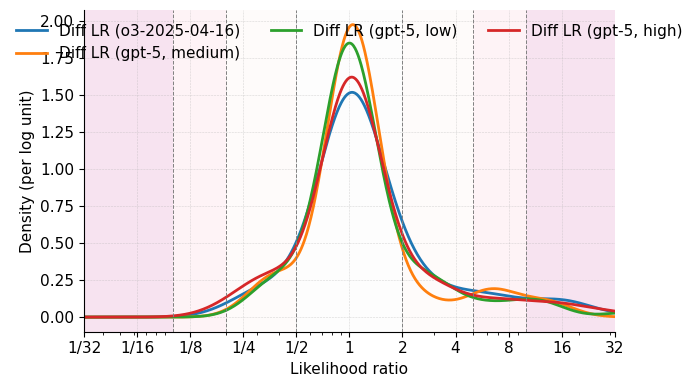

In [19]:
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import FixedLocator, FixedFormatter
from scipy.stats import gaussian_kde
from pathlib import Path

def plot_multi_lr_kde(
    excel_path: str | Path,
    sheet: int | str = 0,
    header_row: int = 0,
    data_start_row: int = 1,
    header_contains: str = r"\bLR\b",   # regex; case-insensitive
    low: float = 1/32,
    high: float = 32,
    n_grid: int = 700,
    bw_method: str | float = "scott",
    min_points: int = 5,
    alpha_bands: float = 0.12,
    legend_loc: str = "upper center",
    legend_ncol: int = 3,
    figsize=(7.0, 4.0),
    savepath: str | Path | None = "columns_to_plot_kde_overlay.pdf",
):
    """
    Overlay KDEs (per log unit) for all columns whose first-row label matches `header_contains`.
    Assumes the data cells in those columns are *LR values* (>0). NaNs & non-positive values are ignored.

    Parameters
    ----------
    excel_path : path to workbook (e.g., 'columns_to_plot.xlsx')
    sheet      : sheet index or name
    header_row : row index containing column labels (default 0)
    data_start_row : first row index containing numeric LR data (default 1)
    header_contains : regex that selects columns by header (default: contains 'LR')
    low, high  : x-range (LR scale), symmetric in log space (default 1/32..32)
    n_grid     : number of x-grid points in log space
    bw_method  : gaussian_kde bandwidth ('scott' | 'silverman' | float)
    min_points : minimum non-NaN values required to draw a KDE for a column
    alpha_bands: alpha for qualitative band shading
    legend_loc : legend location
    legend_ncol: legend columns
    figsize    : figure size
    savepath   : file path to save PDF/PNG; set None to skip saving

    Returns
    -------
    fig, ax
    """
    # -------------------------------------------------------------------------
    # Read sheet exactly as laid out (no header inference)
    df = pd.read_excel(excel_path, sheet_name=sheet, header=None)

    # Identify candidate columns by header regex
    headers = df.iloc[header_row].astype(str)
    mask = headers.str.contains(header_contains, case=True, regex=True)
    cols = np.flatnonzero(mask.values)

    if len(cols) == 0:
        raise ValueError("No columns found whose first-row label matches the regex for 'LR'.")

    # Matplotlib style: clean spines, readable font
    plt.rcParams.update({
        "font.size": 11,
        "axes.spines.right": False,
        "axes.spines.top": False
    })

    # Prebuild x-grid in log10 space; density is per log10 unit (labelled 'per log unit')
    x_log = np.linspace(np.log10(low), np.log10(high), n_grid)
    lr_x  = 10**x_log

    # Qualitative bands (neg/pos strength)
    cuts = [0.1, 0.2, 0.5, 2, 5, 10]
    bands = [(low, 0.1), (0.1, 0.2), (0.2, 0.5), (0.5, 2), (2, 5), (5, 10), (10, high)]
    light = "#fde0dd"; mid = "#fa9fb5"; dark = "#c51b8a"
    band_cols = [dark, mid, light, "#f0f0f0", light, mid, dark]

    # Color cycle for multiple curves
    prop_cycle = plt.rcParams["axes.prop_cycle"]
    colors = prop_cycle.by_key().get("color", ["#0868ac", "#dd3497", "#41ab5d", "#e08214", "#756bb1", "#7b8b8e"])

    fig, ax = plt.subplots(figsize=figsize)

    # Shaded qualitative bands
    for (a, b), col in zip(bands, band_cols):
        ax.axvspan(a, b, color=col, alpha=alpha_bands, lw=0)

    # Iterate columns; compute KDE in log10-space; normalise per log unit
    plotted = 0
    for i, col in enumerate(cols):
        label = str(headers.iloc[col]).strip()

        # Coerce to numeric; use only strictly positive values (LR > 0)
        vals = pd.to_numeric(df.iloc[data_start_row:, col], errors="coerce")
        vals = vals[np.isfinite(vals)]
        vals = vals[vals > 0]

        if vals.size < min_points:
            # Too few points for a stable KDE — skip
            print(f"Skipping '{label}' (n={vals.size} < {min_points}).")
            continue

        log_vals = np.log10(vals.values)
        kde = gaussian_kde(log_vals, bw_method=bw_method)
        pdf = kde(x_log)
        # Normalise so area under pdf over x_log equals 1 (per log unit)
        area = np.trapz(pdf, x_log)
        if area > 0:
            pdf = pdf / area

        ax.plot(lr_x, pdf, lw=2.0, label=label, color=colors[i % len(colors)])
        plotted += 1

    if plotted == 0:
        raise ValueError("No columns had enough positive numeric values to plot.")

    # Log-scale x, fractional ticks
    ticks = [1/32, 1/16, 1/8, 1/4, 1/2, 1, 2, 4, 8, 16, 32]
    def frac_label(t: float) -> str:
        return f"1/{int(round(1/t))}" if t < 1 else f"{int(t)}"
    tick_labels = [frac_label(t) for t in ticks]

    ax.set_xscale("log")
    ax.set_xlim(low, high)
    ax.set_xlabel("Likelihood ratio")
    ax.set_ylabel("Density (per log unit)")

    ax.xaxis.set_major_locator(FixedLocator(ticks))
    ax.xaxis.set_major_formatter(FixedFormatter(tick_labels))

    # Reference lines at band cutoffs
    for c in cuts:
        ax.axvline(c, ls="--", lw=0.7, color="grey")

    ax.grid(which="major", ls="--", lw=0.4, alpha=0.5)
    ax.grid(which="minor", lw=0, alpha=0)

    # Legend
    ax.legend(loc=legend_loc, ncol=legend_ncol, frameon=False)

    fig.tight_layout()

    if savepath is not None:
        savepath = Path(savepath)
        fig.savefig(savepath, dpi=600, bbox_inches="tight")
        print(f"Saved figure to {savepath}")

    return fig, ax


# Example call (same folder as your spreadsheet)
fig, ax = plot_multi_lr_kde(Path('/Users/reblocke/Research/dx_chat_entropy/data_jul_21_2025/columns_to_plot.xlsx'))

#### Bland Altman Plots for agreement of the same tspreadsheet columns

all the pairwise combinations that start with LR

	•	Reads an Excel sheet.
	•	Selects all columns whose first-row header contains “LR” (regex, case-insensitive).
	•	Detects whether the data are raw LR or log-LR (auto, overrideable).
	•	Generates a separate multiplicative (x-fold) Bland–Altman plot for every pairwise comparison among the selected columns.
	•	Annotates mean bias and 95% LoA in ×-fold units.
	•	Uses shared axis limits across all pairs for comparability.
	•	Saves one PDF per pair under ba_pair_plots/.

In [20]:
import re
import itertools
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
from matplotlib.transforms import blended_transform_factory

# Optional: Pingouin for built-in BA panel. We fall back to manual if missing.
try:
    import pingouin as pg
    _HAS_PG = True
except Exception:
    _HAS_PG = False


def _sanitize(name: str) -> str:
    """Safe string for filenames."""
    s = re.sub(r"\s+", "_", str(name).strip())
    s = re.sub(r"[^A-Za-z0-9_.-]", "", s)
    return s[:120]


def plot_pairwise_ba_from_excel(
    excel_path: str | Path,
    sheet: int | str = 0,
    header_row: int = 0,
    data_start_row: int = 1,
    header_regex: str = r"LR",        # select columns whose header contains 'LR'
    assume_scale: str = "auto",       # 'auto' | 'lr' | 'ln'
    outdir: str | Path = "ba_pair_plots",
    point_kwargs: dict | None = None, # e.g. {"s": 15, "alpha": 0.7, "color": "#1b8e5a"}
    line_kwargs: dict | None = None,  # e.g. {"color": "black", "lw": 1.1}
    style_science: bool = True,       # try to use SciencePlots if available
) -> list[Path]:
    """
    Create one Bland–Altman plot per pair of selected columns (multiplicative, x-fold).
    Y-axis = ln-ratio (formatted as ×-fold). X-axis = mean ln (formatted as LR).
    """

    # --- style ---------------------------------------------------------------
    if style_science:
        try:
            plt.style.use(["science", "no-latex"])
        except Exception:
            pass
    plt.rcParams.update({"axes.spines.top": False, "axes.spines.right": False})

    # --- read & select columns ----------------------------------------------
    excel_path = Path(excel_path)
    df = pd.read_excel(excel_path, sheet_name=sheet, header=None)

    headers = df.iloc[header_row].astype(str)
    sel = headers[headers.str.contains(header_regex, case=True, regex=True)]
    if sel.empty:
        raise ValueError("No columns matched header_regex; nothing to compare.")

    # Build dict: label -> numeric series
    series_dict: dict[str, pd.Series] = {}
    for col_idx, label in sel.items():
        s = pd.to_numeric(df.iloc[data_start_row:, col_idx], errors="coerce")
        series_dict[str(label).strip()] = s

    labels = list(series_dict.keys())
    if len(labels) < 2:
        raise ValueError("Need ≥2 matching columns to run pairwise BA comparisons.")

    # --- scale detection (LR vs ln-LR) ---------------------------------------
    def _contains_log_hint(names: list[str]) -> bool:
        pat = re.compile(r"\b(ln|log)\b", re.IGNORECASE)
        return any(pat.search(n) for n in names)

    if assume_scale not in {"auto", "lr", "ln"}:
        raise ValueError("assume_scale must be 'auto', 'lr', or 'ln'.")

    if assume_scale == "ln":
        as_log = True
    elif assume_scale == "lr":
        as_log = False
    else:
        # auto: header hint first, else non-positivity
        if _contains_log_hint(labels):
            as_log = True
        else:
            # If any column has any non-positive value, treat as ln (LR cannot be <= 0)
            any_nonpos = any((s.fillna(np.nan) <= 0).any() for s in series_dict.values())
            as_log = any_nonpos

    # --- helper formatters ---------------------------------------------------
    def fmt_exp(x, _):  # display LR values on ln axis
        return f"{np.exp(x):.2g}"
    x_fmt = FuncFormatter(fmt_exp)

    def fmt_fold(x, _):  # display ×-fold on ln-diff axis
        return f"{np.exp(x):.2g}×"
    y_fmt = FuncFormatter(fmt_fold)

    # --- build ln-series and collect global limits ---------------------------
    ln_data = {}
    for lab, s in series_dict.items():
        s = s.astype(float)
        if as_log:
            ln_data[lab] = s.replace([np.inf, -np.inf], np.nan)
        else:
            # raw LR → ln
            s = s.where(s > 0, np.nan)
            ln_data[lab] = np.log(s)

    # Global limits over all pairwise combos
    means_all, diffs_all = [], []
    pairs = list(itertools.combinations(labels, 2))
    for a, b in pairs:
        A, B = ln_data[a], ln_data[b]
        ok = A.notna() & B.notna()
        if ok.sum() < 3:
            continue
        m = (A[ok] + B[ok]) / 2
        d = (A[ok] - B[ok])
        means_all.append(m.values)
        diffs_all.append(d.values)

    if not means_all:
        raise ValueError("No pair had ≥3 overlapping rows after NaN filtering.")

    means_all = np.concatenate(means_all)
    diffs_all = np.concatenate(diffs_all)
    xlim = (means_all.min(), means_all.max())
    ylim = (-1.1 * np.abs(diffs_all).max(), 1.1 * np.abs(diffs_all).max())

    # --- default aesthetics --------------------------------------------------
    if point_kwargs is None:
        point_kwargs = {"s": 18, "alpha": 0.7}
    if line_kwargs is None:
        line_kwargs = {"color": "black", "lw": 1.1}

    outdir = Path(outdir)
    outdir.mkdir(parents=True, exist_ok=True)

    saved: list[Path] = []

    # --- plot each pair ------------------------------------------------------
    for a, b in pairs:
        A, B = ln_data[a], ln_data[b]
        ok = A.notna() & B.notna()
        if ok.sum() < 3:
            print(f"Skip: '{a}' vs '{b}' (n={ok.sum()} < 3).")
            continue

        x = ((A[ok] + B[ok]) / 2).values  # ln geometric mean
        y = (A[ok] - B[ok]).values        # ln ratio A/B

        mu = y.mean()
        sd = y.std(ddof=1)
        loa_hi = mu + 1.96 * sd
        loa_lo = mu - 1.96 * sd

        fig, ax = plt.subplots(figsize=(5.6, 4.0))

        if _HAS_PG:
            # Pingouin BA adds lines; we will re-style them and re-annotate
            pg.plot_blandaltman(A[ok].values, B[ok].values, ax=ax,
                                marker="o", **{k:v for k,v in point_kwargs.items() if k in {"s","alpha","color"}})
            # mean line then LoA lines:
            ax.lines[0].set(**line_kwargs)  # mean
            for ln in ax.lines[1:]:
                ln.set(linestyle="--", **line_kwargs)
        else:
            # Manual BA
            ax.scatter(x, y, marker="o", **point_kwargs)
            ax.axhline(mu, **line_kwargs)
            ax.axhline(loa_hi, linestyle="--", **line_kwargs)
            ax.axhline(loa_lo, linestyle="--", **line_kwargs)

        # remove any auto text (from pg)
        for t in list(ax.texts):
            t.remove()

        # right-side labels in ×-fold
        trans = blended_transform_factory(ax.transAxes, ax.transData)
        ax.text(0.98, mu,     f"Mean: {np.exp(mu):.2f}×",
                transform=trans, ha="right", va="center", fontsize=11)
        ax.text(0.98, loa_hi, f"95% LoA: {np.exp(loa_hi):.2f}×",
                transform=trans, ha="right", va="bottom", fontsize=11)
        ax.text(0.98, loa_lo, f"95% LoA: {np.exp(loa_lo):.2f}×",
                transform=trans, ha="right", va="top", fontsize=11)

        # axes formatting (ln space; label as LR and ×-fold)
        ax.set_xlim(xlim); ax.set_ylim(ylim)
        ax.xaxis.set_major_formatter(x_fmt)
        ax.yaxis.set_major_formatter(y_fmt)

        ax.set_title(f"{a} vs {b}", fontsize=13)
        ax.set_xlabel("Geometric mean LR", fontsize=12)
        ax.set_ylabel(f"LR ratio ({a} / {b})", fontsize=12)

        fig.tight_layout()

        fname = outdir / f"ba_{_sanitize(a)}__vs__{_sanitize(b)}.pdf"
        fig.savefig(fname, format="pdf", bbox_inches="tight")
        plt.close(fig)
        print(f"Saved: {fname}")
        saved.append(fname)

    return saved

# Example: columns whose first-row header contains 'LR'
files = plot_pairwise_ba_from_excel(
    Path('/Users/reblocke/Research/dx_chat_entropy/data_jul_21_2025/columns_to_plot.xlsx'),
    header_regex=r"LR",        # select headers that contain 'LR'
    assume_scale="auto",       # or 'lr' if raw LRs, 'ln' if log-LRs
    outdir=Path('/Users/reblocke/Research/dx_chat_entropy/data_jul_21_2025/')
)

Saved: /Users/reblocke/Research/dx_chat_entropy/data_jul_21_2025/ba_Diff_LR_o3-2025-04-16__vs__Diff_LR_gpt-5_medium.pdf
Saved: /Users/reblocke/Research/dx_chat_entropy/data_jul_21_2025/ba_Diff_LR_o3-2025-04-16__vs__Diff_LR_gpt-5_low.pdf
Saved: /Users/reblocke/Research/dx_chat_entropy/data_jul_21_2025/ba_Diff_LR_o3-2025-04-16__vs__Diff_LR_gpt-5_high.pdf
Saved: /Users/reblocke/Research/dx_chat_entropy/data_jul_21_2025/ba_Diff_LR_gpt-5_medium__vs__Diff_LR_gpt-5_low.pdf
Saved: /Users/reblocke/Research/dx_chat_entropy/data_jul_21_2025/ba_Diff_LR_gpt-5_medium__vs__Diff_LR_gpt-5_high.pdf
Saved: /Users/reblocke/Research/dx_chat_entropy/data_jul_21_2025/ba_Diff_LR_gpt-5_low__vs__Diff_LR_gpt-5_high.pdf
